### Feature Engineering

* Preceding Load: Previous `n` hours of actual load
* ~Temperature Changes: Previous `n` hours of temperature changes~
* ~Discomfort level~


---
**How to we the belief that the space of functions is in a neighborhood of the historical functions?**

Turn this subjective prior into an empirical one? Load is monotonic on certain
intervals, e.g. from overnight low to daily peak.

Create a daily cubic spline model for every historical day using hourly actual
load as control points. Cluster days according to coefficients in this model. 

Feature: Empirical probability that the current hours is peak.

Feature: Last `n` hours of temperature changes

---

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')

ds.data.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,,,
2015-02-01 00:00:00-05:00,23.00,32,1,0,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,32,2,0,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,32,3,0,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,32,4,0,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,32,5,0,10432,10700.09


### Feature: Preceding `n` Hours of Actual Load

In [3]:
feature_names = ds.features.copy()
X = ds.data[feature_names].copy()
y = ds.data[ds.actual].copy()

num_hours_prior = 32
def prior_load_colname(i : int):
    return f"Actual Load {i} hours prior"

for i in range(num_hours_prior, 0, -1):
    col_name = prior_load_colname(i)
    X[col_name] = y.shift(i)
    feature_names.append(col_name)

# shift the beginning of our data by `num_hours_prior`
# our train/validate/test split allows the training set time period
# to change while the validate and test are both fixed to a year
X = X[num_hours_prior:]
y = y[num_hours_prior:]
X.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,Actual Load 32 hours prior,Actual Load 31 hours prior,Actual Load 30 hours prior,Actual Load 29 hours prior,Actual Load 28 hours prior,Actual Load 27 hours prior,...,Actual Load 10 hours prior,Actual Load 9 hours prior,Actual Load 8 hours prior,Actual Load 7 hours prior,Actual Load 6 hours prior,Actual Load 5 hours prior,Actual Load 4 hours prior,Actual Load 3 hours prior,Actual Load 2 hours prior,Actual Load 1 hours prior
hour,,,,,,,,,,,,,,,,,,,,,
2015-02-02 08:00:00-05:00,1.04,33,9,0,11337.89,11014.87,10795.37,10714.42,10700.09,10765.42,...,12497.52,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14
2015-02-02 09:00:00-05:00,1.04,33,10,1,11014.87,10795.37,10714.42,10700.09,10765.42,10977.36,...,12059.09,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16
2015-02-02 10:00:00-05:00,1.94,33,11,1,10795.37,10714.42,10700.09,10765.42,10977.36,11320.16,...,11728.11,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70
2015-02-02 11:00:00-05:00,5.00,33,12,1,10714.42,10700.09,10765.42,10977.36,11320.16,11744.05,...,11444.38,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70,13596.18
2015-02-02 12:00:00-05:00,8.06,33,13,1,10700.09,10765.42,10977.36,11320.16,11744.05,12071.10,...,11235.13,11156.19,11166.90,11411.51,12075.09,13281.14,13890.16,13705.70,13596.18,13525.34


In [5]:
ds.features

['MSP', 'DayOfYear', 'HourEnding', 'IsBusinessHour']

In [6]:
from validation import Error, walkforward
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(7, weights='distance')

def next_hour(actual, previous_hour, predicted_load):
    next = actual.copy()
    # HACK: assume the temps are forecasted...
    for i in range(num_hours_prior, 1, -1):
        next[prior_load_colname(i)] = previous_hour[prior_load_colname(i-1)].iloc[0]

    next[prior_load_colname(1)] = predicted_load
    return next

(predictions, errors) = walkforward(knn, X, y,
                                    ds.validation_start, ds.validation_end, next_hour, X.columns.to_list())
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=484.5578855406549, max=3814.6395903535868, total=4244727.077336128)


In [10]:
active_features = X.columns.to_list()
active_features.remove('MSP')
(predictions, errors) = walkforward(knn, X, y,
                                    ds.validation_start, ds.validation_end, next_hour, active_features)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=484.5348732584393, max=3814.6452020227225, total=4244525.489743922)


At least for our naive similarity model, temperature deosn't seem to matter much.

In [11]:
from sklearn.feature_selection import r_regression
r_regression(ds.train_data[['MSP']], ds.train_data[ds.actual])

array([-0.07044126])

In [12]:
sorted([(X.columns[i], v) for (i,v) in enumerate(r_regression(X[:ds.train_end], y[:ds.train_end]))], key=lambda r: -r[1])

[('Actual Load 1 hours prior', 0.9698708392592658),
 ('Actual Load 2 hours prior', 0.8908018194871311),
 ('Actual Load 24 hours prior', 0.8826428493634659),
 ('Actual Load 23 hours prior', 0.8595862452472319),
 ('Actual Load 25 hours prior', 0.8503471567758594),
 ('Actual Load 22 hours prior', 0.7907847703188762),
 ('Actual Load 3 hours prior', 0.7813373717223855),
 ('Actual Load 26 hours prior', 0.7721270946412156),
 ('Actual Load 21 hours prior', 0.692821631825158),
 ('Actual Load 27 hours prior', 0.6645479816814707),
 ('Actual Load 4 hours prior', 0.6568357851679486),
 ('Actual Load 20 hours prior', 0.5800198696831458),
 ('Actual Load 28 hours prior', 0.5421580748867164),
 ('Actual Load 5 hours prior', 0.5301035726446124),
 ('Actual Load 19 hours prior', 0.46469888256616976),
 ('HourEnding', 0.44193192144989824),
 ('Actual Load 29 hours prior', 0.41765625501264064),
 ('Actual Load 6 hours prior', 0.4124904317770146),
 ('IsBusinessHour', 0.4012964105815318),
 ('Actual Load 18 hours p

In [13]:
correlated_prior_hours = [1, 2, 23, 24, 25]
correlated_columns = [prior_load_colname(i) for i in correlated_prior_hours]
def next_hour(actual, previous_hour, predicted_load):
    next = actual.copy()
    next[prior_load_colname(1)] = predicted_load
    for i in correlated_prior_hours[1:]:
        next[prior_load_colname(i)] = previous_hour[prior_load_colname(i-1)].iloc[0]
    return next

knn = KNeighborsRegressor(6, weights='distance')
(predictions, errors) = walkforward(knn, X, y, ds.validation_start, ds.validation_end, next_hour,
                                    correlated_columns)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=509.15754919719893, max=3403.1030505945346, total=4460220.130967453)


In [14]:
uncorrelated_features = ['DayOfYear', 'IsBusinessHour', 'HourEnding']
knn = KNeighborsRegressor(5, weights='distance')
(predictions, errors) = walkforward(knn, X, y, ds.validation_start, ds.validation_end, next_hour,
                                    correlated_columns + uncorrelated_features)
overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
print(overall_error)

Error(mae=517.7335004555458, max=2982.981972837528, total=4535345.463990563)


In [16]:
mtlf_error = Error(ds.validation_data[ds.actual], ds.validation_data[ds.mtlf])
print(f'MTLF {mtlf_error}')

MTLF Error(mae=222.98570091324197, max=2217.33, total=1953354.7399999993)


Our naive model still does not perform well. We are about 2.5x worse on the MTLF MAE and 1.5x worse on the maximum error.

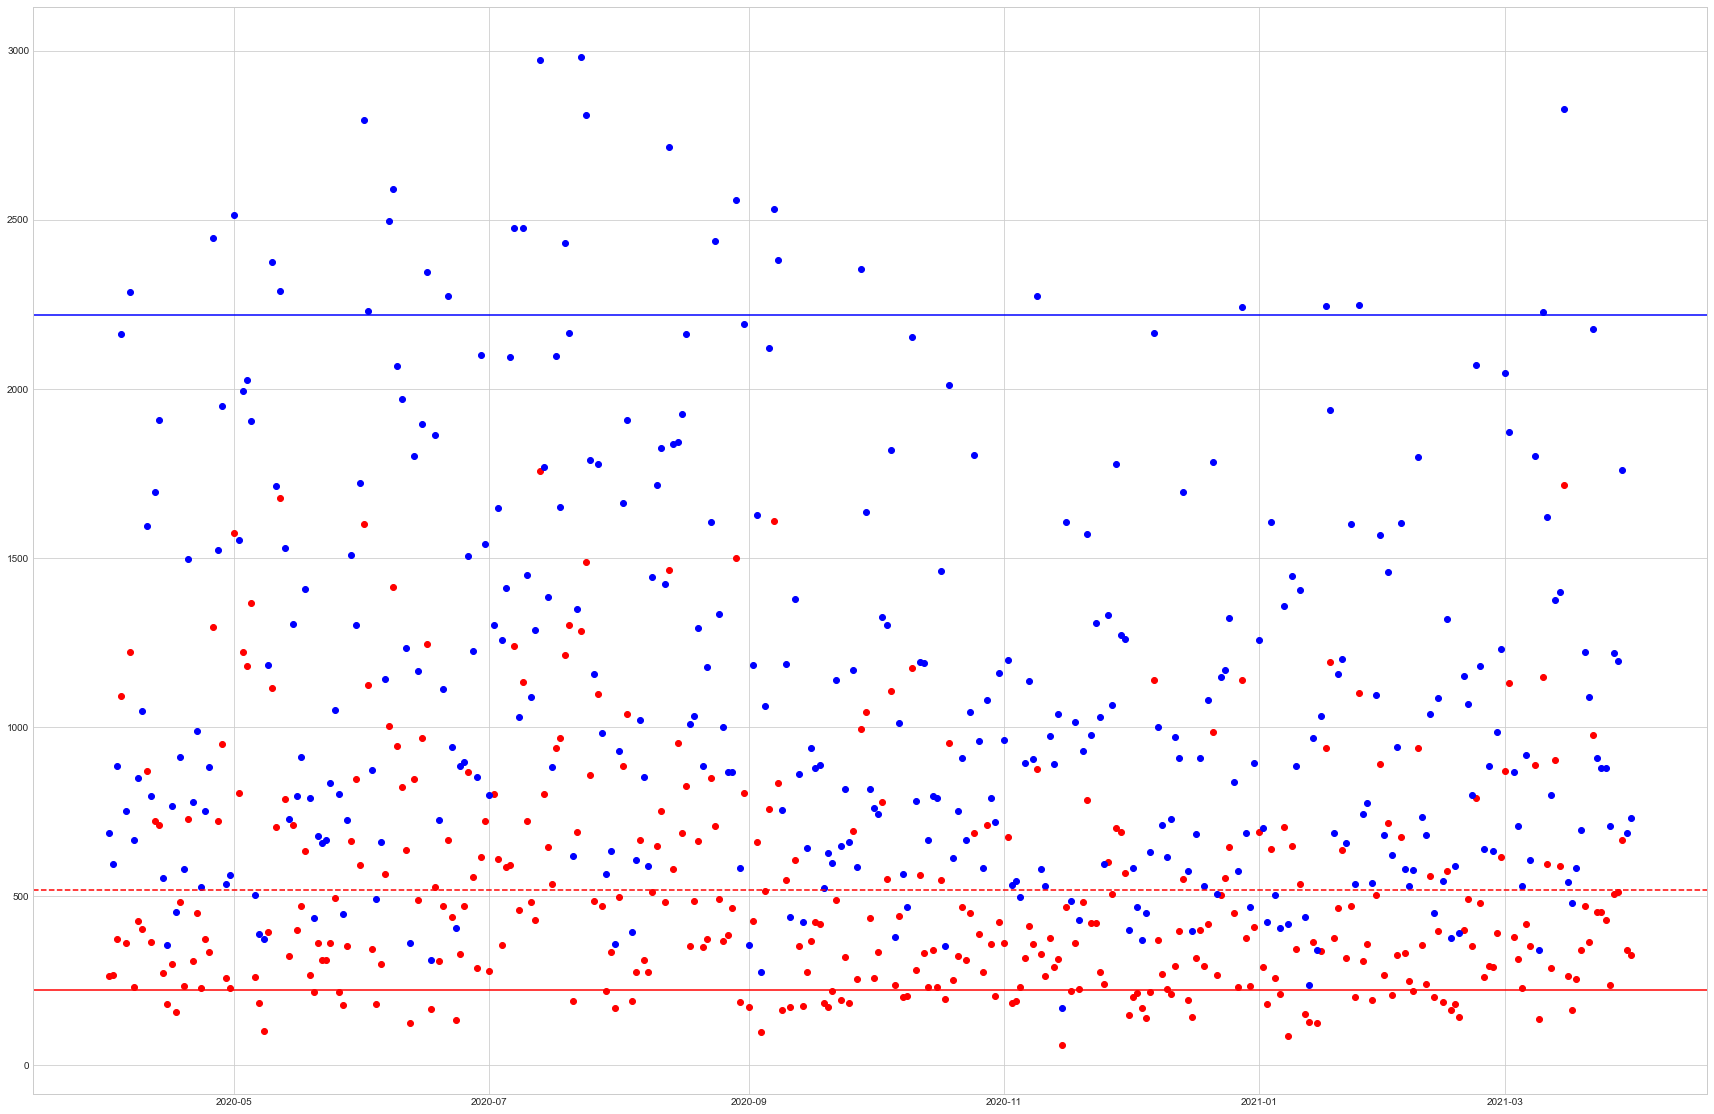

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

mae = [e.mae for e in errors]
maxe = [e.max for e in errors]
dates = ds.validation_data.index.to_series()[::24].array
plt.figure(figsize=(30, 20))
plt.plot(dates, mae, 'ro', dates, maxe, 'bo')
plt.axhline(y=mtlf_error.mae, color='r', linestyle='-')
plt.axhline(y=overall_error.mae, color='r', linestyle='--')
plt.axhline(y=mtlf_error.max, color='b', linestyle='-')
plt.show()

### Observations and Next Steps

The limits of our naive model are apparent. In the next notebook, we will explore linear models.

In [18]:
save_data = X.join(y).join(ds.data[ds.mtlf], how='inner')
assert save_data.shape[0] == X.shape[0]
save_data.to_parquet('data/zone1_prior_load.parquet')